In [121]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

df = pd.read_csv('weatherHistory.csv')
sequence = df.Summary.tolist()
d = dict(sorted(Counter(sequence).items(), key=lambda x: x[1], reverse=True))
d

{'Partly Cloudy': 31733,
 'Mostly Cloudy': 28094,
 'Overcast': 16597,
 'Clear': 10890,
 'Foggy': 7148,
 'Breezy and Overcast': 528,
 'Breezy and Mostly Cloudy': 516,
 'Breezy and Partly Cloudy': 386,
 'Dry and Partly Cloudy': 86,
 'Windy and Partly Cloudy': 67,
 'Light Rain': 63,
 'Breezy': 54,
 'Windy and Overcast': 45,
 'Humid and Mostly Cloudy': 40,
 'Drizzle': 39,
 'Breezy and Foggy': 35,
 'Windy and Mostly Cloudy': 35,
 'Dry': 34,
 'Humid and Partly Cloudy': 17,
 'Dry and Mostly Cloudy': 14,
 'Rain': 10,
 'Windy': 8,
 'Humid and Overcast': 7,
 'Windy and Foggy': 4,
 'Dangerously Windy and Partly Cloudy': 1,
 'Windy and Dry': 1,
 'Breezy and Dry': 1}

In [122]:
from typing import List

class SkipGramDataset(Dataset):
    def __init__(self, sequence: List = sequence, block_size=5):
        self._sequence = sequence

        self.block_size = block_size
        self.value_counts = dict(sorted(Counter(sequence).items(), key=lambda x: x[1], reverse=True))
        self.labels = list(self.value_counts.keys())

        sequence = [self.labels.index(item) for item in self._sequence]
        # sequence = torch.tensor(sequence).unique_consecutive().tolist()
        self.sequence = sequence
    
    def __len__(self):
        return len(self.sequence) - self.block_size + 1
    
    def __getitem__(self, idx):
        sequence = self.sequence[idx:idx+self.block_size]
        center = sequence.pop(self.block_size//2)
        return torch.tensor(center), torch.tensor(sequence)


In [123]:
embedding = nn.Embedding(len(d), len(d))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(embedding.parameters(), lr=.01)
from tqdm import tqdm

epoch = 50
block_size = 7
for e in tqdm(range(epoch)):
    for target, context in DataLoader(SkipGramDataset(block_size=block_size), batch_size=128, shuffle=True):
        optimizer.zero_grad()

        loss = criterion(embedding(target.repeat(block_size-1, 1).T.flatten(0)), context.flatten(0))

        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:42<00:00,  1.18it/s]


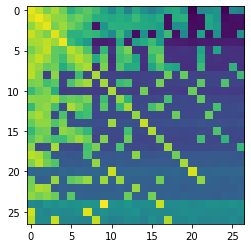

In [124]:
plt.imshow(embedding.weight.detach().numpy())
plt.show()

In [125]:
from sklearn.decomposition import PCA

embed = embedding.weight.detach().numpy()

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(embed)

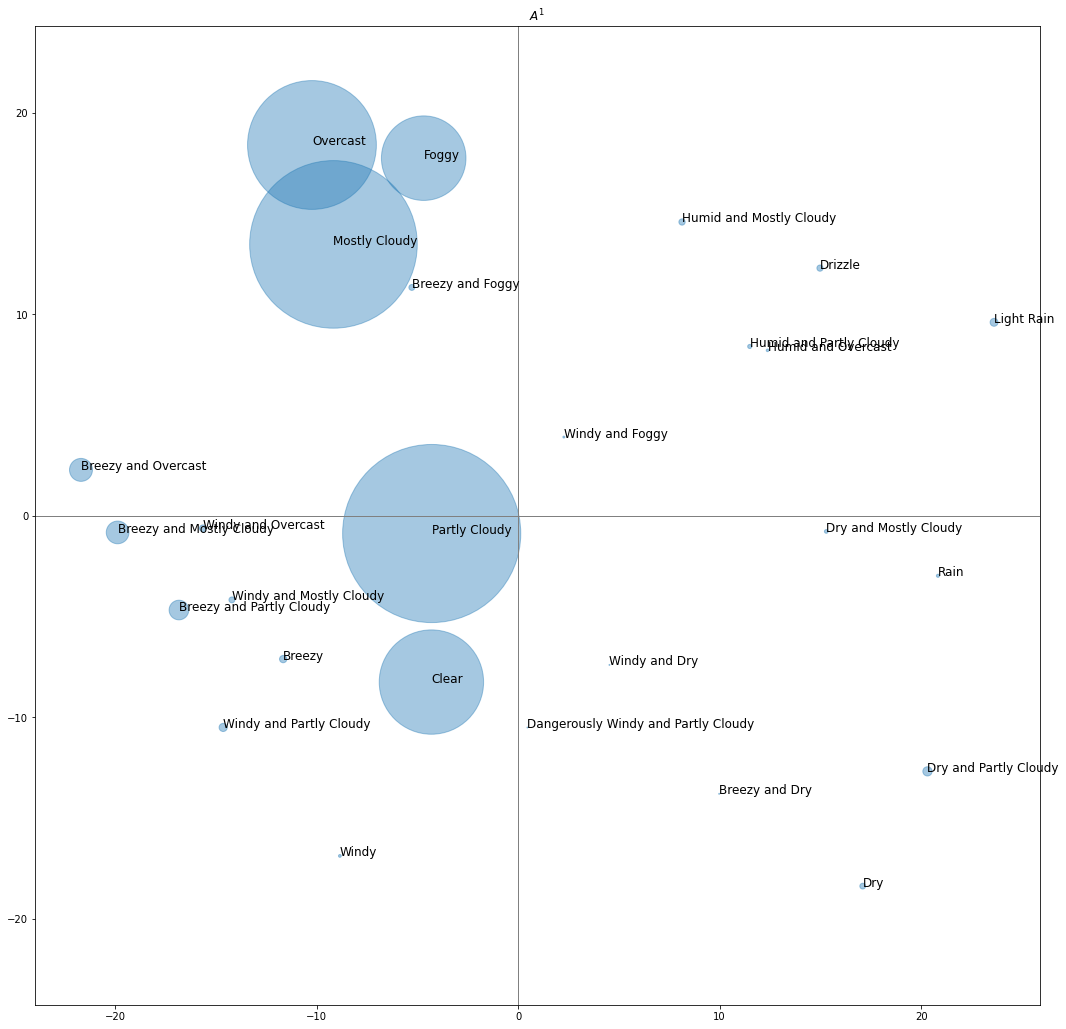

In [126]:
z = embedding(torch.arange(0, len(d))).detach().cpu()

plt.figure(figsize=(18,18))
plt.title(r'$A^1$')
plt.scatter(*pca_2d.T, s=torch.tensor(list(d.values())), alpha=.4)
plt.axis('equal')
plt.axvline(0, lw=1, c='grey')
plt.axhline(0, lw=1, c='grey')
for i in range(len(d)):
    plt.text(*pca_2d[i], s=list(d.keys())[i], fontsize=12)
plt.show()